In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plotsize = (13, 5)

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [4]:
# Read the data from the csv file
df_daily = pd.read_csv("coffee-prices-historical-chart-data.csv")

# Change the dtype of the columns 'date' from object to datetime64[ns]
df_daily = df_daily.astype({'date': "datetime64[ns]"})

# Set the column 'date' as index
df_daily.set_index('date', inplace=True)

# From the 2022-01-21 there are no more values. Therefore, we drop this rows
df_daily = df_daily[:"2022-01-21"]

print(f"\n The dataframe has {len(df_daily)} rows and {len(df_daily.columns)} columns.")
df_daily.describe()


 The dataframe has 12147 rows and 1 columns.


,value
count,12147.000000
mean,1.267276
std,0.478930
min,0.425000
25%,0.948500
50%,1.237000
75%,1.470000
max,3.356300


In [5]:
print(df_daily.index)

DatetimeIndex(['1973-08-20', '1973-08-21', '1973-08-22', '1973-08-23',
               '1973-08-24', '1973-08-27', '1973-08-28', '1973-08-29',
               '1973-08-30', '1973-08-31',
               ...
               '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-01-21'],
              dtype='datetime64[ns]', name='date', length=12147, freq=None)


In [6]:
print(f'\n Unique dates in our data: {len(df_daily.index.unique())}.')

# Compute range of dates in the dataset
our_range = df_daily.index.max() - df_daily.index.min()

# Number of days in date range
print(f'\n Total days in our date range: {our_range.days} days.')


 Unique dates in our data: 12147.

 Total days in our date range: 17686 days.


In [7]:
# Define new index for the dataset
new_index = pd.date_range(df_daily.index.min(), df_daily.index.max())

# Replace the old index with the new and fill missing values with NaN
df_daily = df_daily.reindex(new_index, fill_value=np.nan)

print(df_daily.index)

DatetimeIndex(['1973-08-20', '1973-08-21', '1973-08-22', '1973-08-23',
               '1973-08-24', '1973-08-25', '1973-08-26', '1973-08-27',
               '1973-08-28', '1973-08-29',
               ...
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-01-21'],
              dtype='datetime64[ns]', length=17687, freq='D')


In [8]:
print(f"\n Number of NaN values in dataset: {df_daily.isna().sum().sum()}.")


 Number of NaN values in dataset: 5540.


In [9]:
df_daily = df_daily.interpolate(method='linear', axis=0)
print(f"\n Number of NaN values in dataset: {df_daily.isna().sum().sum()}.")
df_daily.describe()


 Number of NaN values in dataset: 0.


,value
count,17687.000000
mean,1.265767
std,0.479077
min,0.425000
25%,0.944767
50%,1.235833
75%,1.469250
max,3.356300


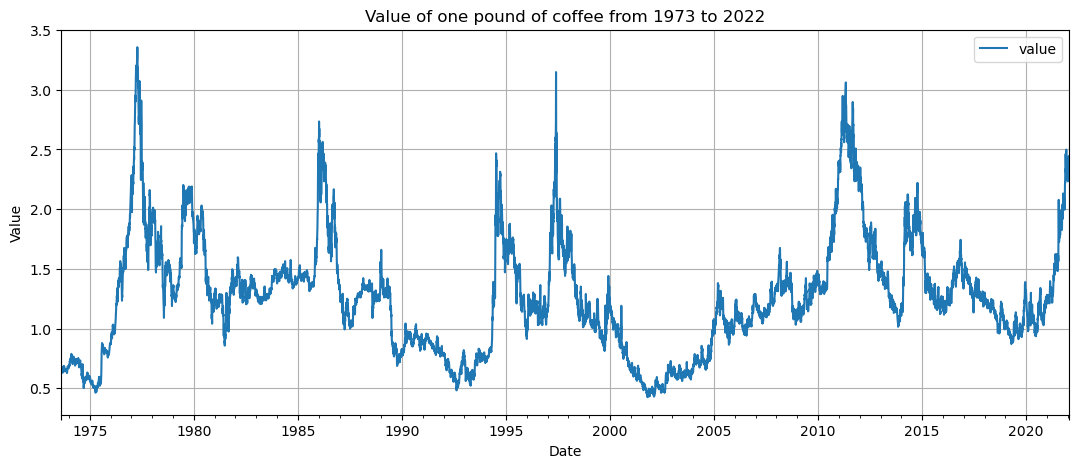

In [10]:
df_daily.plot(figsize=plotsize, 
              grid=True, 
              title="Value of one pound of coffee from 1973 to 2022", 
              xlabel="Date",
              ylabel="Value")
plt.show()

In [11]:
# Resample the data from daily to monthly and quartal
df_monthly = df_daily.resample('M').mean()
df_quartal = df_daily.resample("Q").mean()

C:\Users\JOSE\AppData\Local\Temp\ipykernel_16624\3928806819.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_daily.resample('M').mean()
C:\Users\JOSE\AppData\Local\Temp\ipykernel_16624\3928806819.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quartal = df_daily.resample("Q").mean()


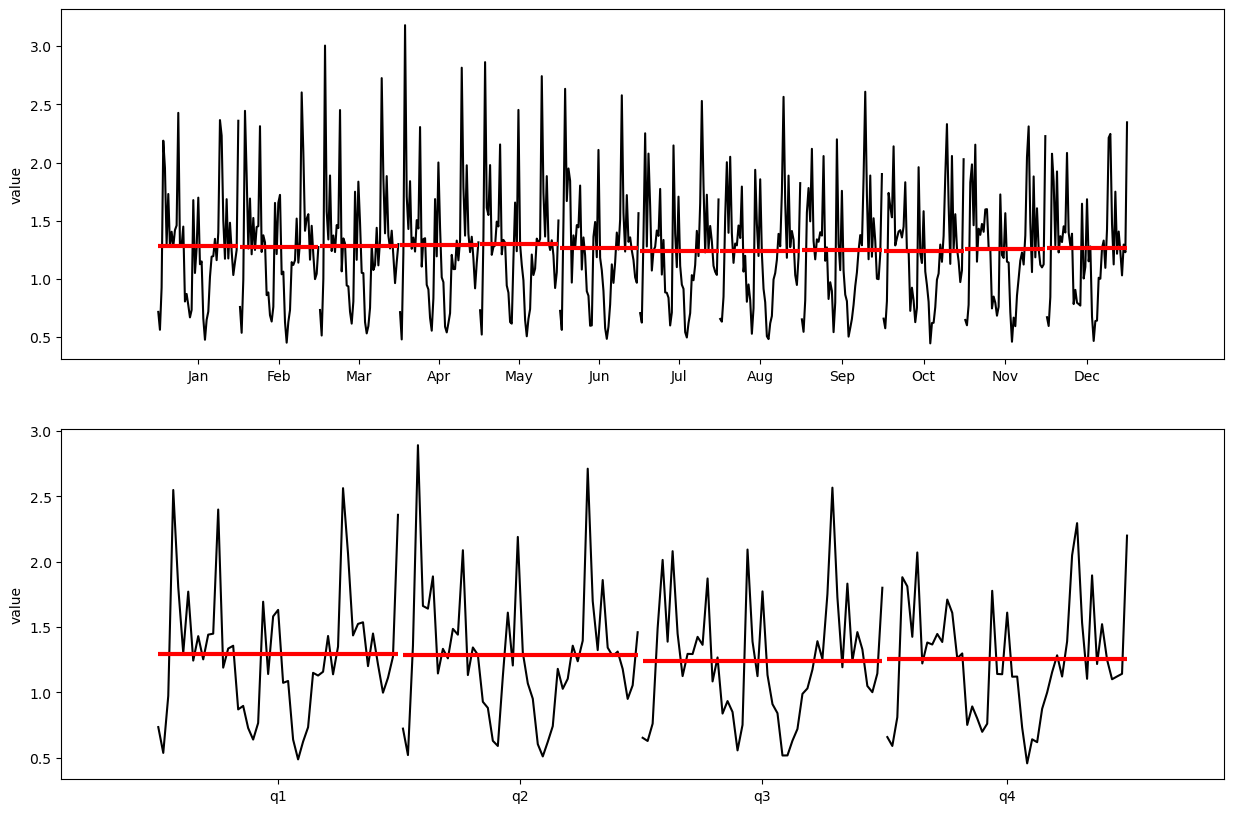

In [12]:
# Seasonal plot of monthly/quartal data.

fig, axes = plt.subplots(2, 1, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

month_plot(df_monthly['value'], ylabel="value", ax=axes[0])
quarter_plot(df_quartal['value'], ylabel="value", ax=axes[1])

plt.show()

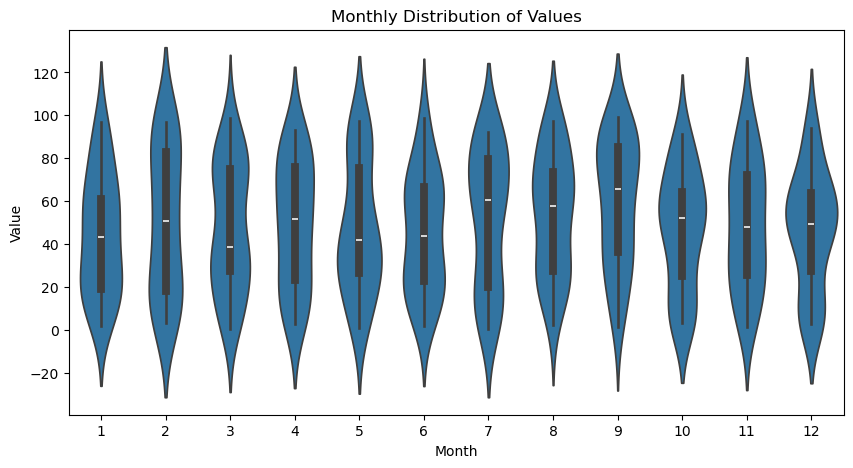

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Creating sample data
np.random.seed(42)
dates = pd.date_range(start="2022-01-01", periods=365, freq="D")
values = np.random.rand(365) * 100

# Creating DataFrame
df_daily = pd.DataFrame({"Date": dates, "Value": values})

# Extracting the month correctly
df_daily["Month"] = df_daily["Date"].dt.month  

# Plotting
plt.figure(figsize=(10, 5))
sns.violinplot(x=df_daily["Month"], y=df_daily["Value"])

# Setting labels
plt.xlabel("Month")
plt.ylabel("Value")
plt.title("Monthly Distribution of Values")

# Show plot
plt.show()


In [14]:
# Compute the decomposition
ss_decomposition = seasonal_decompose(x=df_monthly, model='additive')

# Extract the trend
estimated_trend = ss_decomposition.trend

# Extract the seasonality
estimated_seasonal = ss_decomposition.seasonal

# Extract the residual
estimated_residual = ss_decomposition.resid

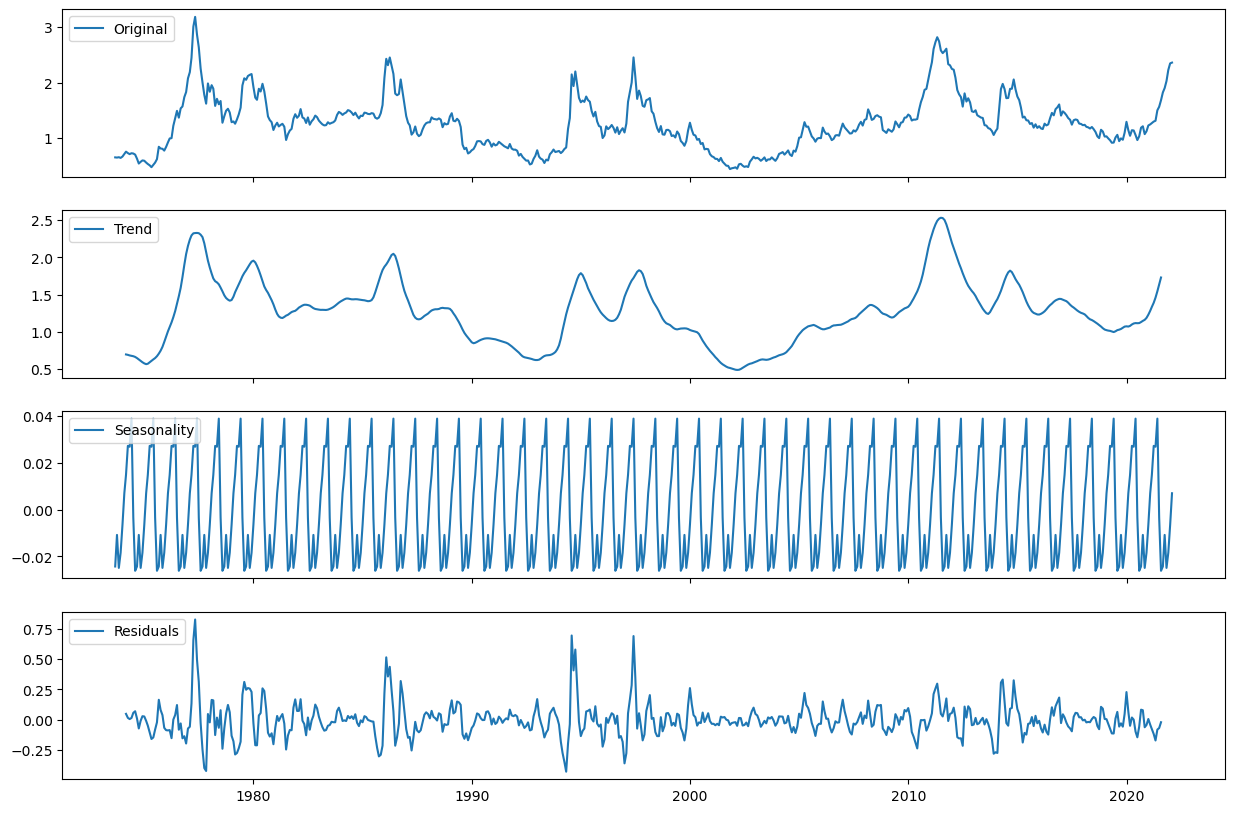

In [15]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)


axes[0].plot(df_monthly, label='Original')
axes[0].legend(loc='upper left');


axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

    
axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

    
axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');
plt.show()

Test Statistic             -0.743963
p-value                     0.835031
Lags Used                   0.000000
Observations Used       17686.000000
Critical Value (1%)        -3.430720
Critical Value (5%)        -2.861703
Critical Value (10%)       -2.566857
dtype: float64


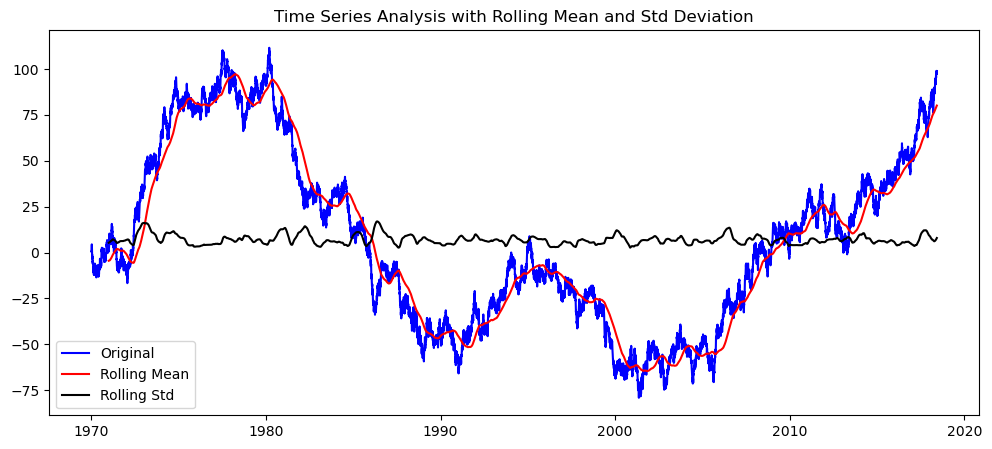

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

# Generate a sample time series dataset
np.random.seed(42)
dates = pd.date_range(start="1970-01-01", periods=17687, freq="D")  # Simulated daily data
values = np.random.randn(len(dates)).cumsum()  # Random walk to simulate trend

df = pd.DataFrame({"Date": dates, "Value": values})
df.set_index("Date", inplace=True)

# Perform Augmented Dickey-Fuller Test
def dftest(timeseries):
    result = ts.adfuller(timeseries)
    df_output = pd.Series(result[0:4], 
                          index=['Test Statistic', 'p-value', 'Lags Used', 'Observations Used'])
    
    for key, value in result[4].items():
        df_output[f'Critical Value ({key})'] = value
    
    print(df_output)

# Run the ADF test
dftest(df["Value"])

# Calculate rolling mean and rolling standard deviation
window_size = 365  # 1-year rolling window
rolling_mean = df["Value"].rolling(window=window_size).mean()
rolling_std = df["Value"].rolling(window=window_size).std()

# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(df["Value"], color="blue", label="Original")  # Original time series
plt.plot(rolling_mean, color="red", label="Rolling Mean")  # Moving average
plt.plot(rolling_std, color="black", label="Rolling Std")  # Rolling standard deviation

# Add title and legend
plt.title("Time Series Analysis with Rolling Mean and Std Deviation")
plt.legend()
plt.show()
